# Morphing water vapor from SAPHIR
### Erfan Jahangir and Brian Mapes May 2018

Matlab codes have been used to create a set of hourly "synths" consisting of NaN-filled arrays with one orbit swath of data advected to the (hourly) target hour. 

Here we composite them into past and future composites, then process those
---------


In [1]:
import numpy as np 
import glob             # to list available files
import scipy.io as spio # to read the .mat files
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
plt.rcParams['animation.html'] = 'jshtml'
from PIL import Image
import datetime

In [2]:
%matplotlib inline 

In [10]:
# Hardwire the structure of the files and dimensions

DX = 0.5 # degrees
SOUTH = -60 # Central latitudes of southern grid  cells
NORTH = 60  # " " northern " " 
WEST = 0 # Central longitude of westernmost cell
EAST = 360 # " " easternmost " 

# Build 1D spatial coordinate arrays 
NLAT = int( (NORTH-SOUTH)/DX +1)
lat = np.linspace(SOUTH, NORTH, NLAT)

NLON = int( (EAST-WEST)/DX +1) 
lon = np.linspace(WEST, EAST, NLON) - 180.0 # Checked with independent dataset 

-----
# FUTURE (backward advected) and PAST (forward advected) 
------

-------------
# Functions to create/update future and past composites
## works from files in arbitrary order
-------------

In [24]:
def update_future_composite(futurefiles_wildcard, WV_future, minobtime): 
     
# Before calling for the first time, build these arrays like this 
# Make lat x lon containers full of NaN for the WV and minimum ob time
#    WV_future = np.zeros( (NLAT,NLON) ); WV_future.fill(np.nan)
#    minobtime = np.zeros( (NLAT,NLON) ) + 9.99e19 # huge so any obs time will be less
    
    
# Loop over files, updating arrays wherever the obtime is smaller than the existing value
    print(np.size(glob.glob(futurefiles_wildcard)), ' files')
    for idx,filename in enumerate(glob.iglob(futurefiles_wildcard), start=0):
        mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        
# Extract the "synth" data and time arrays, and set -999 values to NaN
        synth = mat['synth']
        data = synth.gridded        
        data [data < 0] = np.nan
        obtime = synth.sourcetime + data*0  # this will propagate the nan values
        

# Grab the areas that are useful (that is, are the least-far in the future)
        useful = obtime < minobtime ### Ignore warings from comparing NaN to numbers. 
        WV_future[useful] = data  [useful]
        minobtime[useful] = obtime[useful]

        
### Display it
        fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
        WV = axarr[0].imshow(WV_future, cmap='viridis_r')
        axarr[0].set_title('Future data composite so far '+filename)
        fig.colorbar(WV, ax=axarr[0])
# time      
        tob = axarr[1].imshow(24*((minobtime+WV_future*0) - (prodtime.days + prodtime.seconds/3600./24.)))
        axarr[1].set_title('Relative time of closest observation so far (hours)')
        fig.colorbar(tob, ax=axarr[1])
                
    return(WV_future, minobtime + WV_future*0) # NAN mask for minobtime

In [25]:
def update_past_composite(pastfiles_wildcard, WV_past, maxobtime): 
     
# Before calling for the first time, build these arrays like this 
# Make lat x lon containers full of NaN for the WV and maximum ob time
#    WV_past   = np.zeros( (NLAT,NLON) ); WV_past.fill(np.nan)
#    maxobtime = np.zeros( (NLAT,NLON) )  # zero so any obs time will be greater
    
# Loop over files, updating arrays wherever the obtime is greater than the existing value
    print(np.size(glob.glob(pastfiles_wildcard)), ' files')
    for idx,filename in enumerate(glob.iglob(pastfiles_wildcard), start=0):
        mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        
# Extract the "synth" data and time arrays, and set -999 values to NaN
        synth = mat['synth']
        data = synth.gridded        
        data [data < 0] = np.nan
        obtime = synth.sourcetime + data*0  # this will propagate the nan values
        
# Grab the areas that are useful (that is, are the least-far in the future)
        useful = obtime > maxobtime   ### Ignore warings from comparing NaN to numbers. 
        WV_past[useful]   = data  [useful]
        maxobtime[useful] = obtime[useful]
        
        
### Display it
        fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
        WV = axarr[0].imshow(WV_past, cmap='viridis_r')
        axarr[0].set_title('Past data composite so far '+filename)
        fig.colorbar(WV, ax=axarr[0])
# time      
        tob = axarr[1].imshow(24*((maxobtime+WV_past*0) - (prodtime.days + prodtime.seconds/3600./24.)))
        axarr[1].set_title('Relative time of closest observation so far (hours)')
        fig.colorbar(tob, ax=axarr[1])
                
    return(WV_past, maxobtime + WV_past*0) # NaN mask for maxobtime

------------
# Set time of desired hourly product:
------------

In [48]:
now = datetime.datetime(2012,1,2,0,0) + datetime.timedelta(hours=3)
prodtime = now - datetime.datetime(1970, 1, 1)

print(now.strftime('%Y%m%dT%H'), prodtime)

20120102T03 15341 days, 3:00:00


## Now build it up by composite

In [49]:
## future data (which has been "backward" advected) 
futurefiles_wildcard = '../SAPHIR-morphing-data-201201_7days/Synths/*backward*' + now.strftime('%Y%m%dT%H') +'*mat'
#print(glob.glob(futurefiles_wildcard))

In [50]:
## past data (which has been "forward" advected) 
pastfiles_wildcard = '../SAPHIR-morphing-data-201201_7days/Synths/*forward*' + now.strftime('%Y%m%dT%H') +'*mat'
#print( glob.glob(pastfiles_wildcard))

14  files


//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


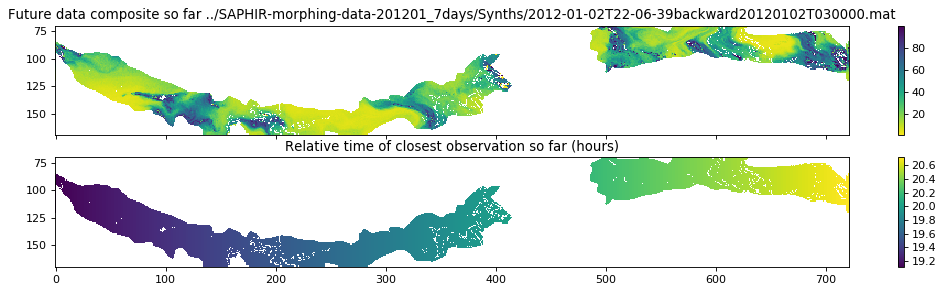

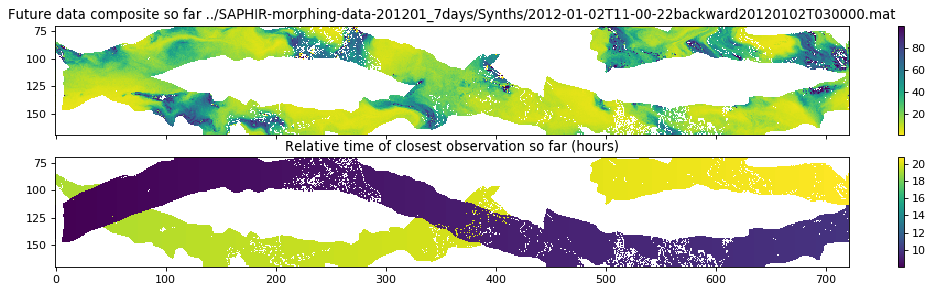

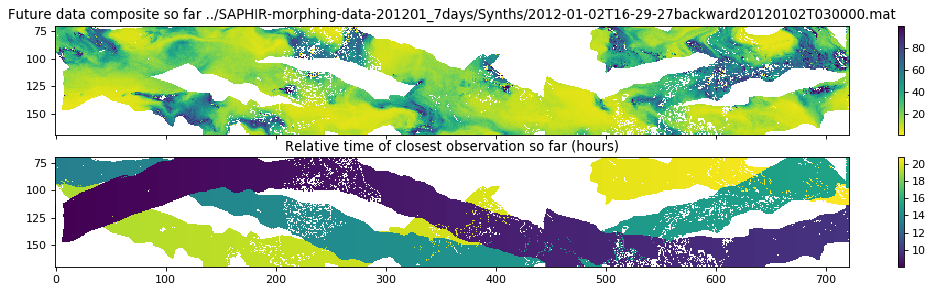

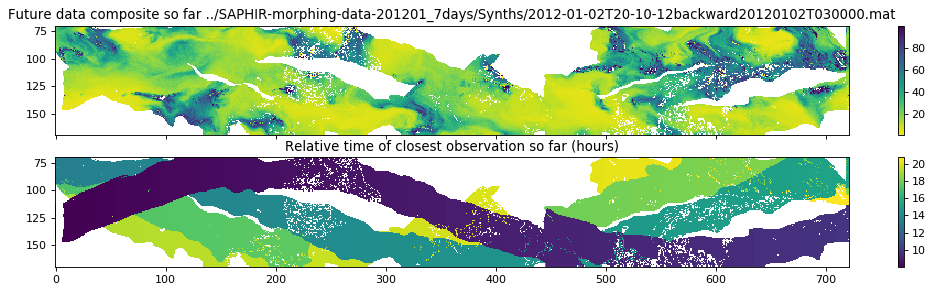

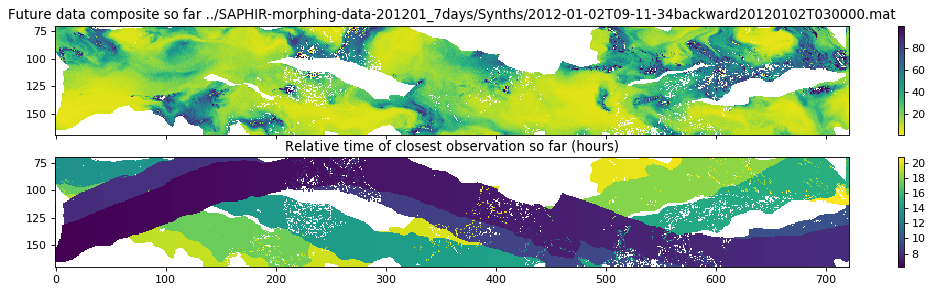

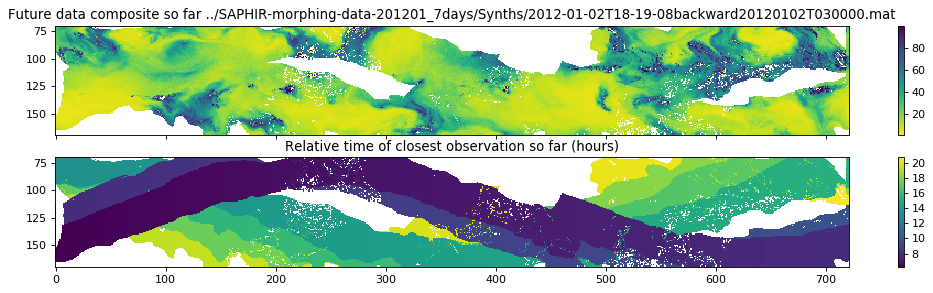

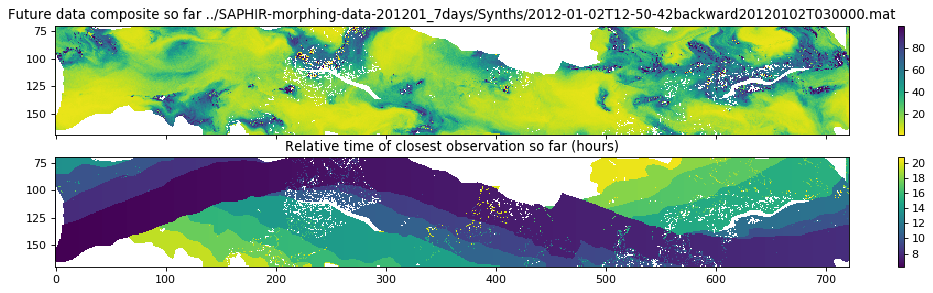

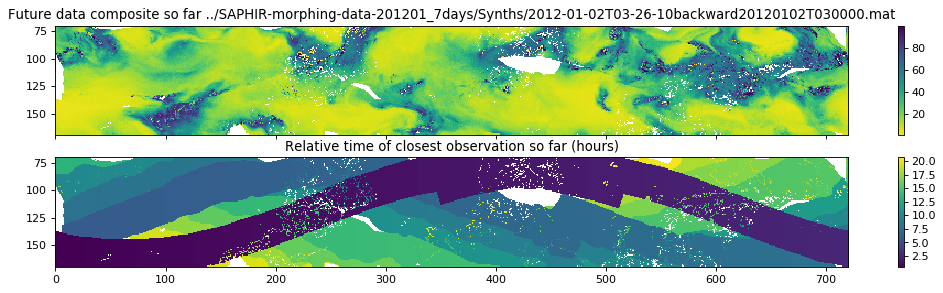

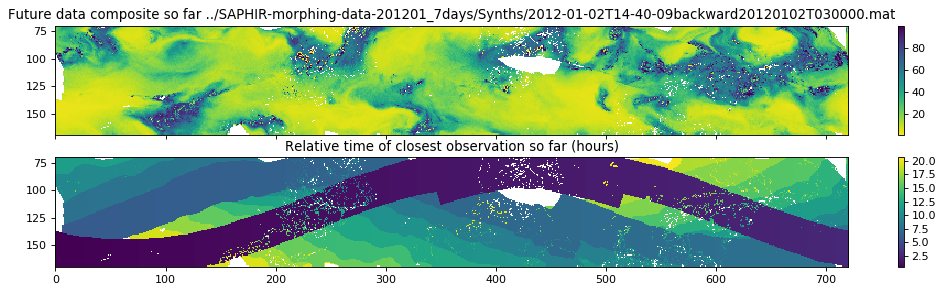

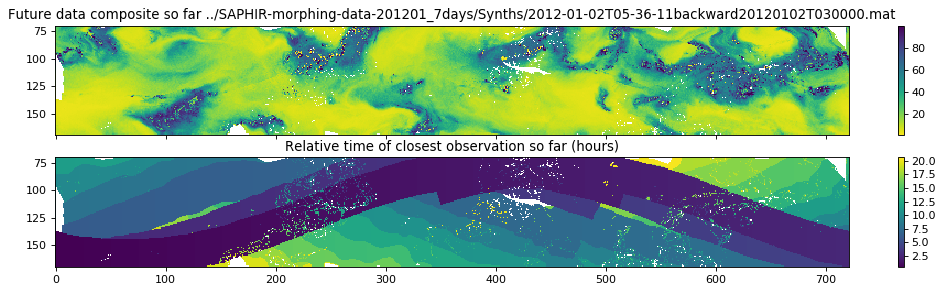

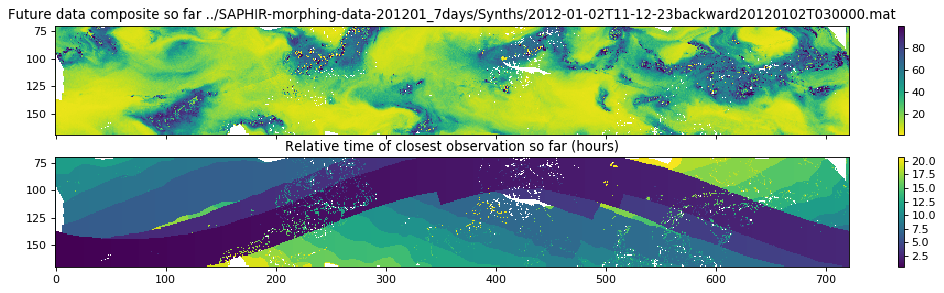

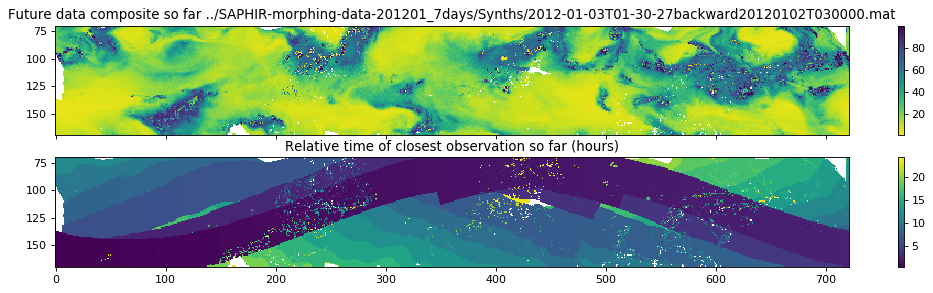

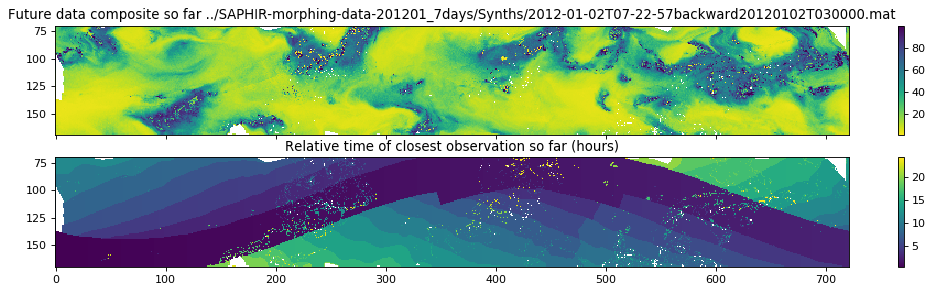

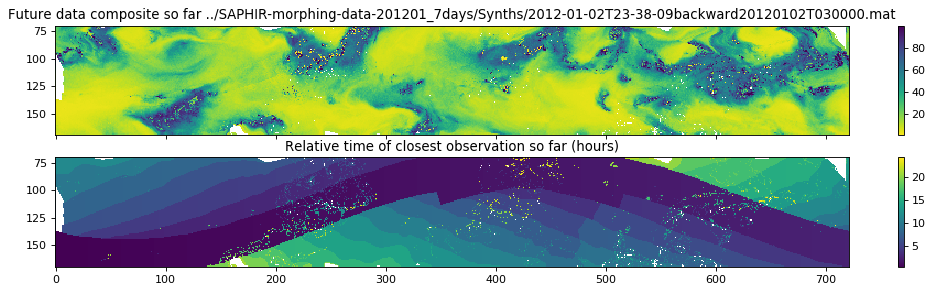

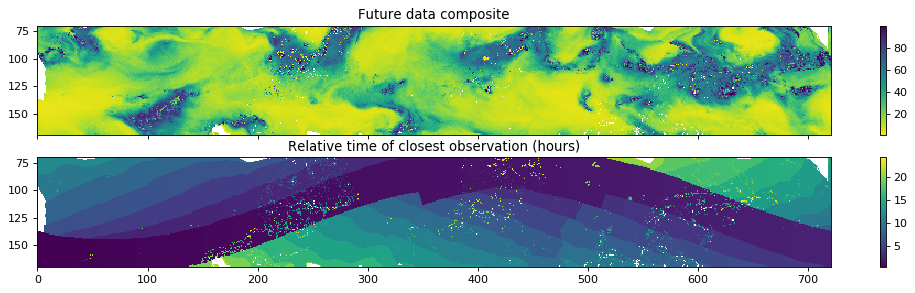

In [51]:
### FUTURE array update
WV_future = np.zeros( (NLAT,NLON) ); WV_future.fill(np.nan)
minobtime = np.zeros( (NLAT,NLON) ) + 9.99e19 # huge so any obs time will be less

WV_future, minobtime = update_future_composite(futurefiles_wildcard, WV_future, minobtime)


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WV = axarr[0].imshow(WV_future, cmap='viridis_r')
axarr[0].set_title('Future data composite')
fig.colorbar(WV, ax=axarr[0])
# time      
tob = axarr[1].imshow(24*(minobtime - (prodtime.days + prodtime.seconds/3600./24.)))
axarr[1].set_title('Relative time of closest observation (hours)')
fig.colorbar(tob, ax=axarr[1])

12  files


//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


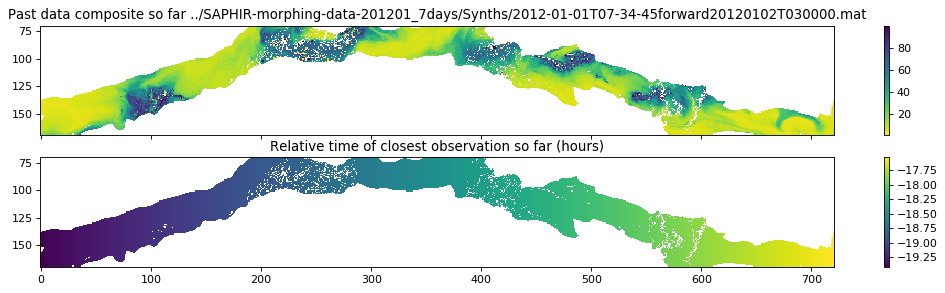

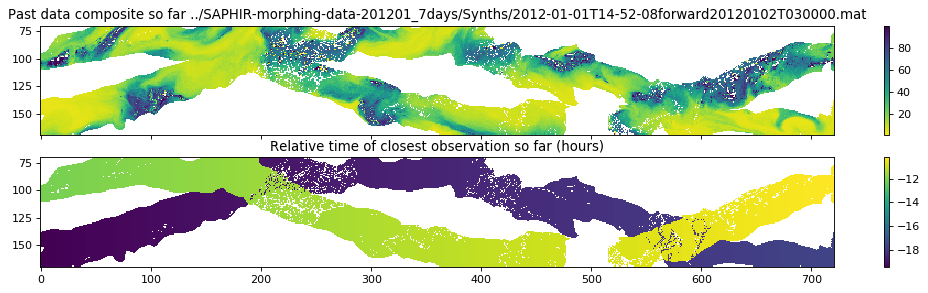

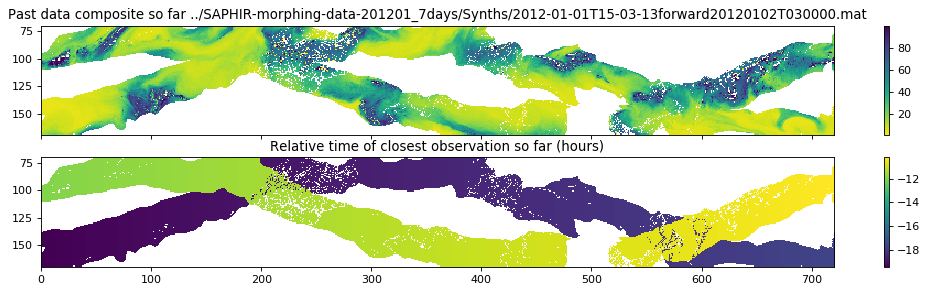

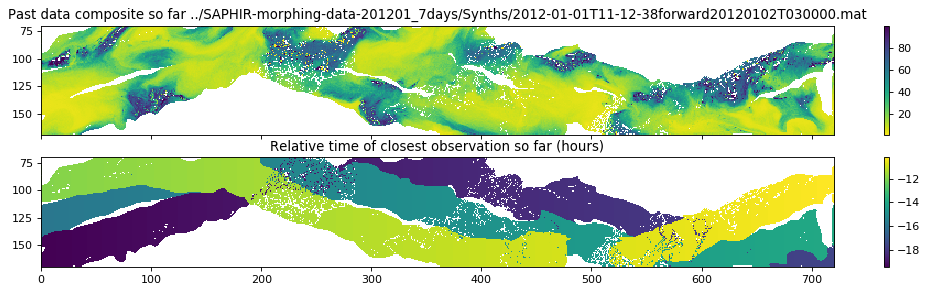

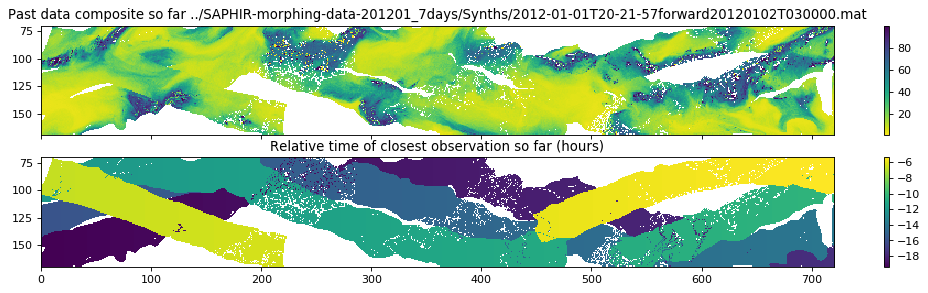

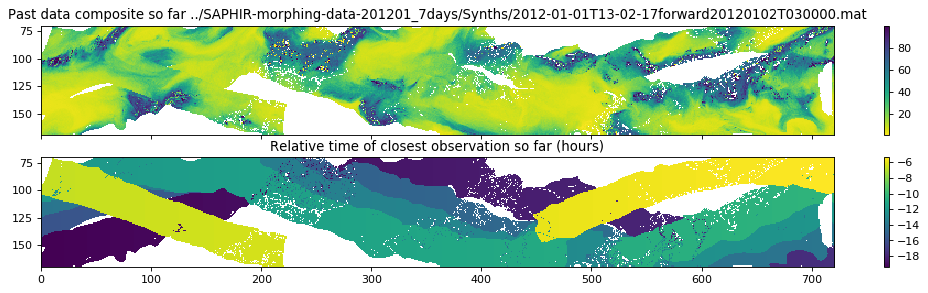

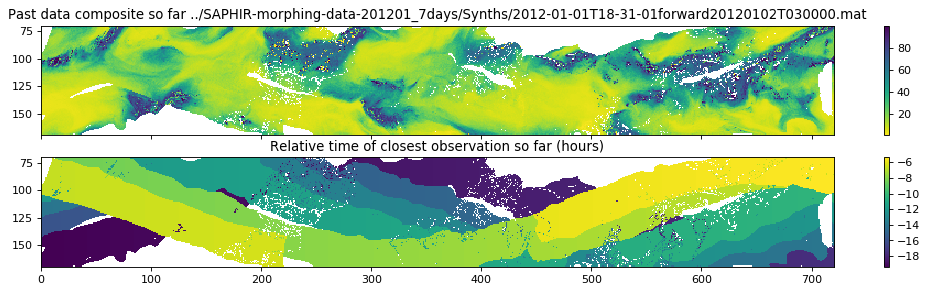

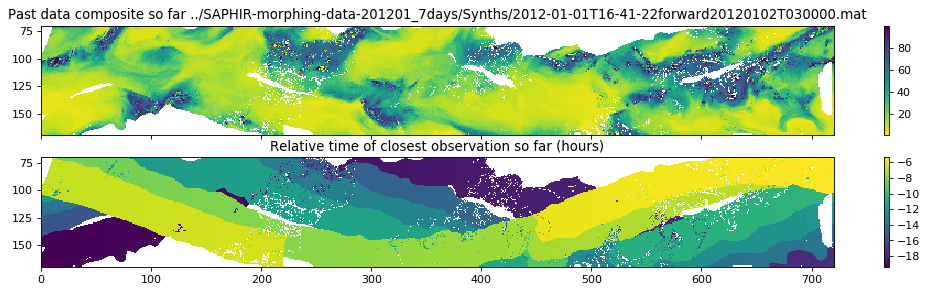

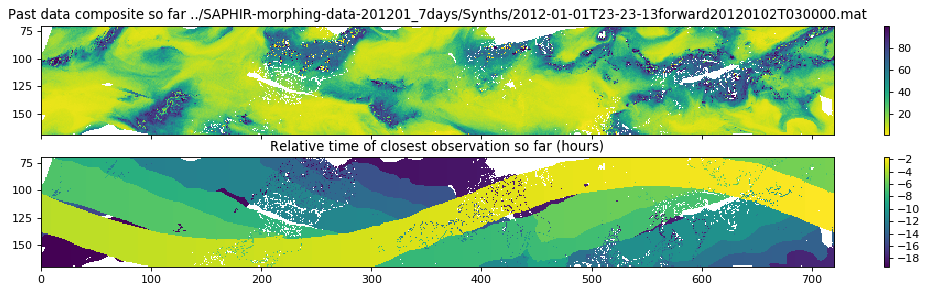

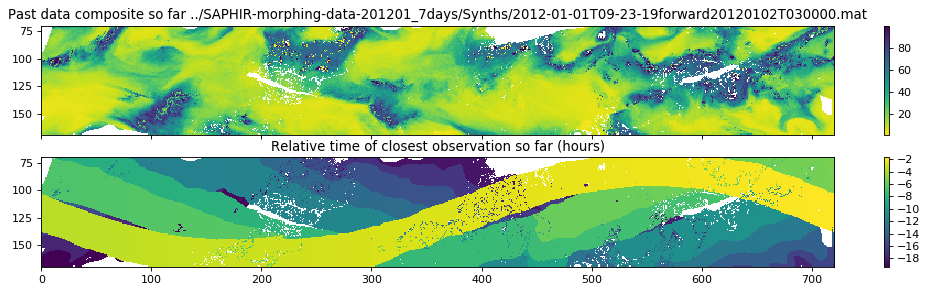

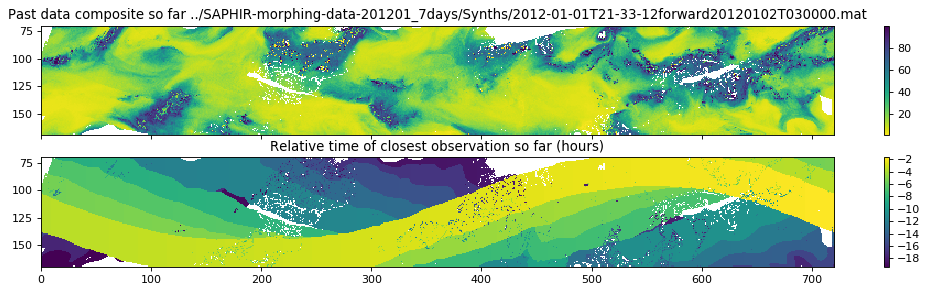

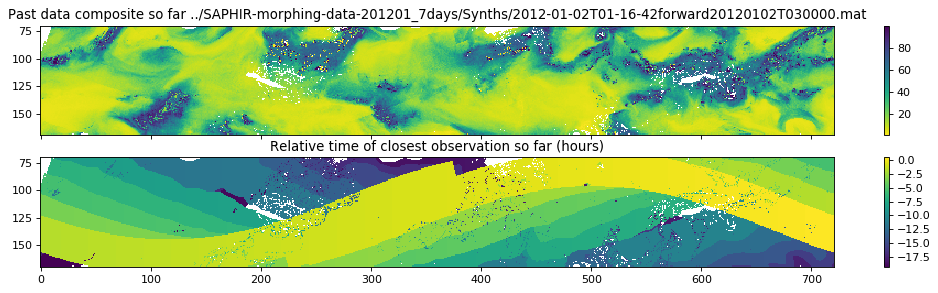

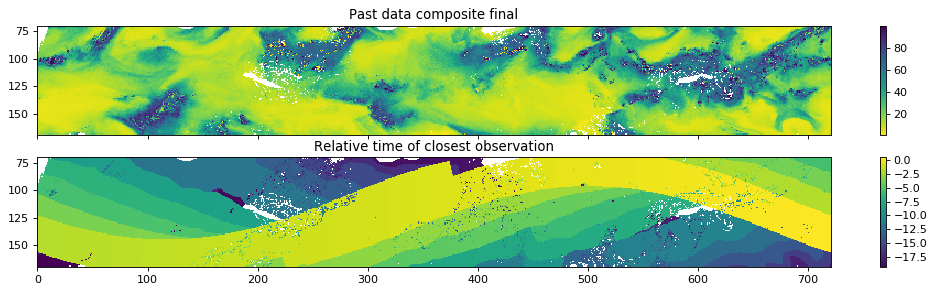

In [52]:
### update PAST arrays
WV_past = np.zeros( (NLAT,NLON) ); WV_past.fill(np.nan)
maxobtime = np.zeros( (NLAT,NLON) ) - 999. # negative, so any obs time will be greater

WV_past, maxobtime = update_past_composite(pastfiles_wildcard, WV_past, maxobtime)


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WV = axarr[0].imshow(WV_past, cmap='viridis_r')
axarr[0].set_title('Past data composite final')
fig.colorbar(WV, ax=axarr[0])
# time           
tob = axarr[1].imshow(24*(maxobtime - (prodtime.days + prodtime.seconds/3600./24.)))
axarr[1].set_title('Relative time of closest observation')
fig.colorbar(tob, ax=axarr[1])

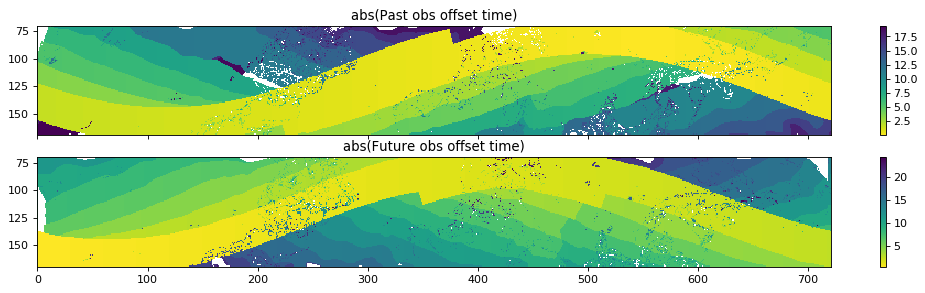

In [66]:
past_offset   = 24*abs(maxobtime - prodtime.days - prodtime.seconds/3600./24.)
future_offset = 24*abs(minobtime - prodtime.days - prodtime.seconds/3600./24.)


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# past
past = axarr[0].imshow(past_offset, cmap='viridis_r')
axarr[0].set_title('abs(Past obs offset time)')
fig.colorbar(past, ax=axarr[0])
# time           
future = axarr[1].imshow(future_offset, cmap='viridis_r')
axarr[1].set_title('abs(Future obs offset time)')
fig.colorbar(future, ax=axarr[1])

# Median filter to remove speckle
## For the time offset, set NaN values to 24h before median filtering. 

Text(0.5,1,'past offset filtered 4')

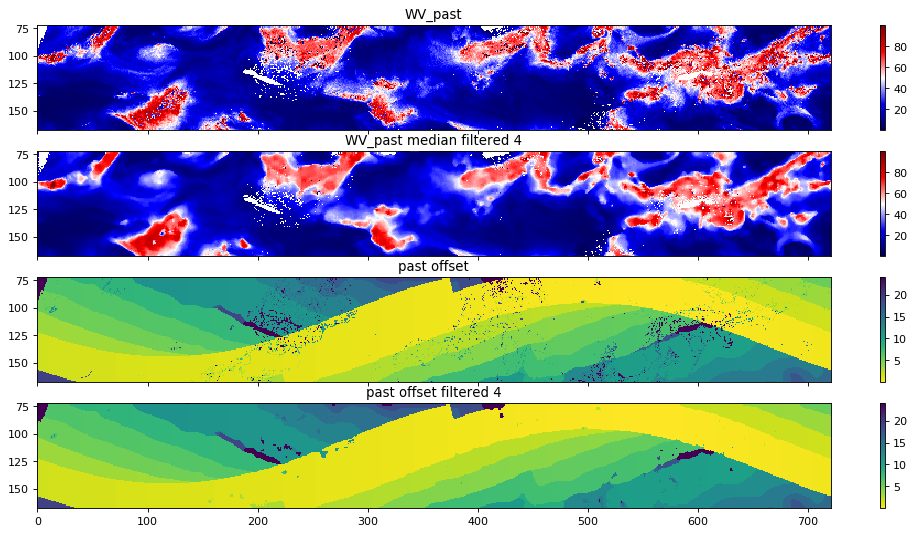

In [69]:
from scipy import ndimage

# Filter the data
WVp_filt = ndimage.median_filter(WV_past, 4)

# Filter the time offset variable
poff = past_offset 
poff[np.isnan(poff)] = 24
past_filt = ndimage.median_filter(poff, 4)



### Display it all for past: 4 panels
fig, axarr = plt.subplots(4, sharex=True, figsize=(16, 8), dpi=80)

# WV_past
WVim = axarr[0].imshow(WV_past, cmap='seismic')
fig.colorbar(WVim, ax=axarr[0])
axarr[0].set_title('WV_past')

# despeckled           
WVim_filt = axarr[1].imshow(WVp_filt, cmap='seismic')
fig.colorbar(WVim_filt, ax=axarr[1])
axarr[1].set_title('WV_past median filtered 4')

# dt_past
dtim = axarr[2].imshow(poff, cmap='viridis_r')
fig.colorbar(dtim, ax=axarr[2])
axarr[2].set_title('past offset')

# despeckled           
dtim_filt = axarr[3].imshow(past_filt, cmap='viridis_r')
fig.colorbar(dtim_filt, ax=axarr[3])
axarr[3].set_title('past offset filtered 4')



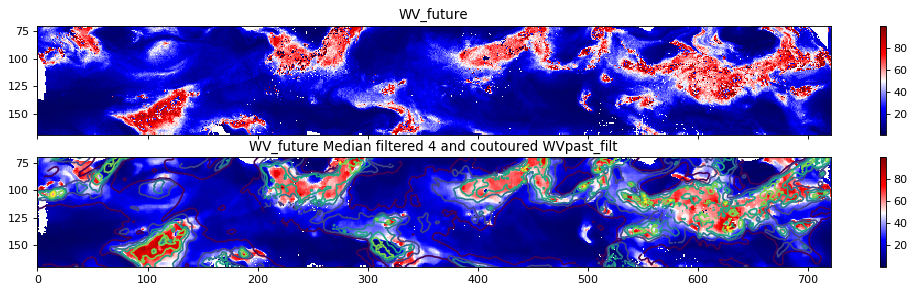

In [70]:
# Median filter of future image, anc contour past to see if advection is right direction 
# (eastward in southern hemisphere westerlies). Yes it is. 

WVf_filt = ndimage.median_filter(WV_future, 4)

# Filter the time offset variable
foff = future_offset 
foff[np.isnan(foff)] = 24
future_filt = ndimage.median_filter(foff, 4)



### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV_past
WVim = axarr[0].imshow(WV_future, cmap='seismic')
fig.colorbar(WVim, ax=axarr[0])
axarr[0].set_title('WV_future')

# despeckled           
WVim_filt = axarr[1].imshow(WVf_filt, cmap='seismic')
fig.colorbar(WVim_filt, ax=axarr[1])
axarr[1].set_title('WV_future Median filtered 4 and coutoured WVpast_filt')
axarr[1].contour(WVp_filt)

# Combine future and past
## 1. Weighted sum: WV
## 2. d/dt, called AT (Analysis Tendency)

Text(0.5,1,'Time rate of change (Lagrangian) %/hour')

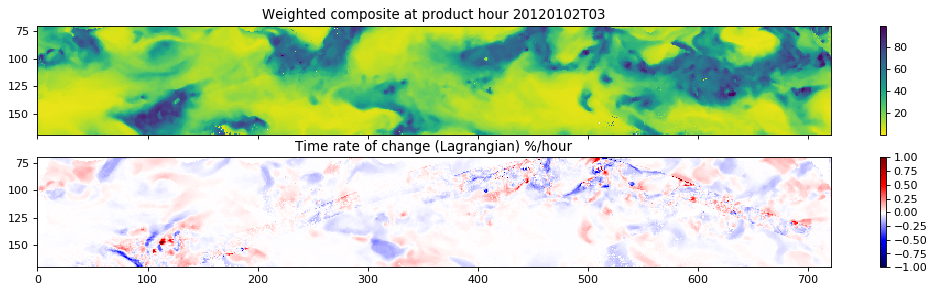

In [73]:
# Median filter to remove speckle
MEDIAN_AREA = 4

WVf_filt = ndimage.median_filter(WV_future, MEDIAN_AREA)
WVp_filt = ndimage.median_filter(WV_past, MEDIAN_AREA)

# Filter the time offset variable: past, filling gaps with 24h
poff = past_offset 
poff[np.isnan(poff)] = 24
past_filt = ndimage.median_filter(poff, MEDIAN_AREA)

# Filter the time offset variable: future, filling gaps with 24h
foff = future_offset 
foff[np.isnan(foff)] = 24
future_filt = ndimage.median_filter(foff, MEDIAN_AREA)


# AT is the derivative: I find it is WAY TOO LARGE when denominator is small. 
AT = (WVf_filt - WVp_filt)/(poff + foff)

# Proximity-weighted average of the two estimates
WV = (WVf_filt*poff + WVf_filt*foff)/(poff + foff)

# Fill in the places where one or the other estimate (future or past) is missing
WV[np.isnan(WVf_filt)] = WVp_filt [np.isnan(WVf_filt)]
WV[np.isnan(WVp_filt)] = WVf_filt [np.isnan(WVp_filt)]


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WVim = axarr[0].imshow(WV, cmap='viridis_r')
fig.colorbar(WVim, ax=axarr[0])
axarr[0].set_title('Weighted composite at product hour '+now.strftime('%Y%m%dT%H'))

# time           
ATim = axarr[1].imshow(AT/24., vmin=-1, vmax=1, cmap='seismic')
fig.colorbar(ATim, ax=axarr[1])
axarr[1].set_title('Time rate of change (Lagrangian) %/hour')